In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential,Model
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
# Set up data paths
data_dir = 'Emotions'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# List of emotions
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

In [3]:
def load_images(directory):
    images = []
    labels = []
    for emotion_index, emotion in enumerate(emotions):
        emotion_dir = os.path.join(directory, emotion)
        for img_file in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_file)
            img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(emotion_index)
    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(emotions))
y_test_cat = to_categorical(y_test, num_classes=len(emotions))

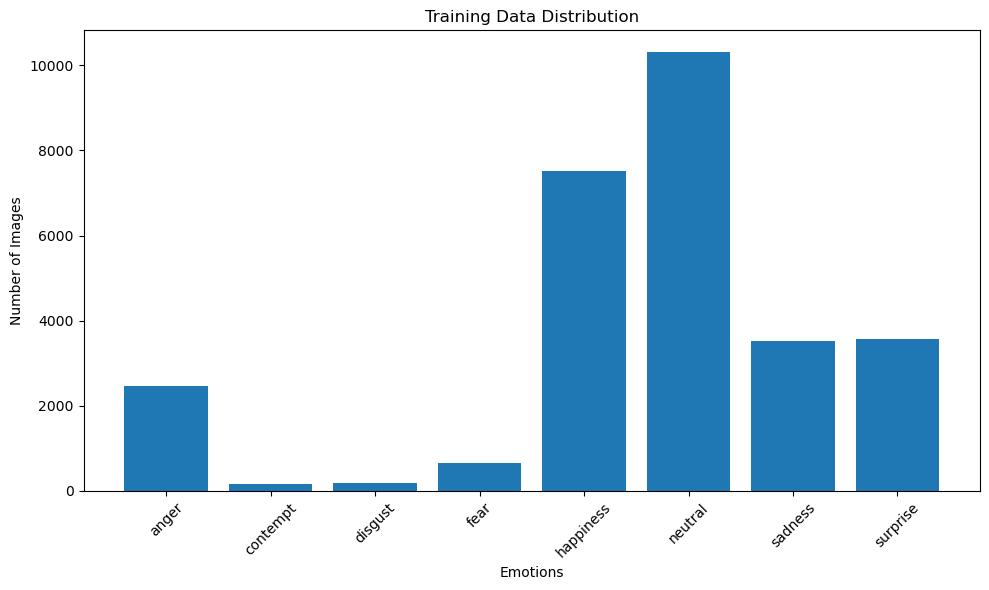

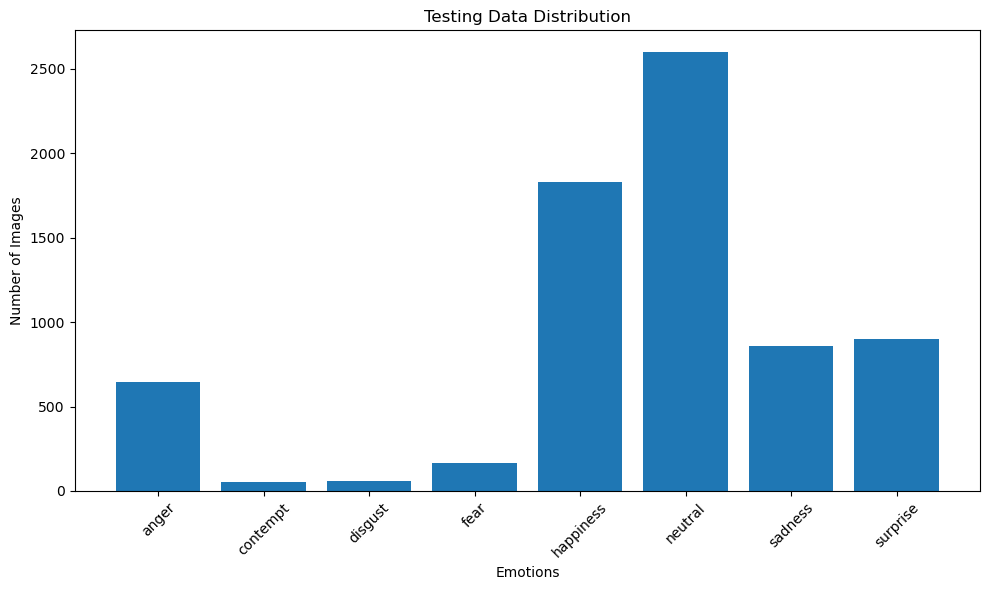

Training data shape: (28386, 48, 48, 1)
Testing data shape: (7099, 48, 48, 1)


In [4]:
def plot_emotion_distribution(labels, title):
    emotion_counts = [np.sum(labels == i) for i in range(len(emotions))]
    plt.figure(figsize=(10, 6))
    plt.bar(emotions, emotion_counts)
    plt.title(title)
    plt.xlabel('Emotions')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_emotion_distribution(y_train, 'Training Data Distribution')
plot_emotion_distribution(y_test, 'Testing Data Distribution')

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

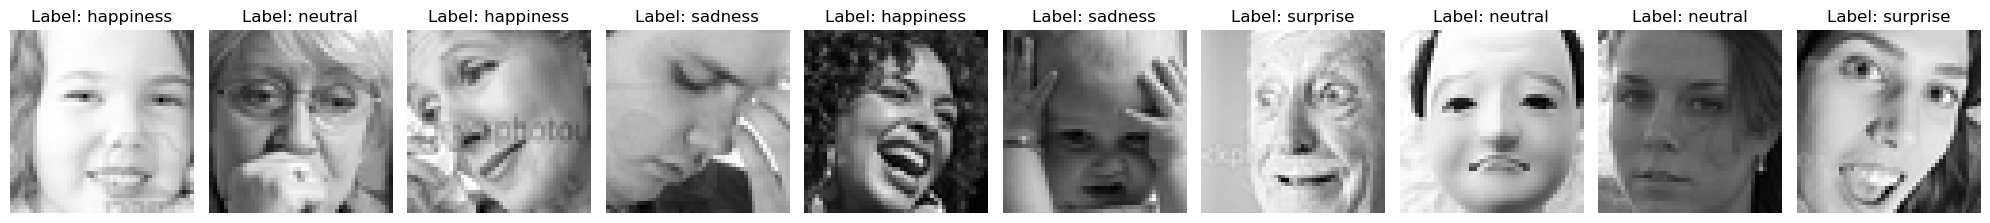

In [5]:
# Displaying the images
def display_random_images(X, y, emotions, num_samples=5):
    plt.figure(figsize=(20, 20))
    unique_indices = np.random.choice(range(len(y)), num_samples, replace=False)
    
    for i, idx in enumerate(unique_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx].reshape(48, 48), cmap='gray')
        plt.title(f'Label: {emotions[y[idx]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_random_images(X_train, y_train, emotions, num_samples=10)

In [6]:
# Creating a validation set 
X_train, X_val, y_train_cat, y_val_cat = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

In [7]:
# Reshaping images to (48, 48, 3) to match ResNet50 input shape
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Model 1: Resnet50

In [9]:
# Creating the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(len(emotions), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 48, 48, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 54, 54, 3)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 24, 24, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 24, 24, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 24, 24, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 26, 26, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 12, 12, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 12, 12, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 12, 12, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 12, 12, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 12, 12, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 12, 12, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 12, 12, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 12, 12, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 12, 12, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,694,088 (98.02 MB)

 Trainable params: 2,106,376 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=32
)

Epoch 1/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 201s 273ms/step - accuracy: 0.3583 - loss: 1.6432 - val_accuracy: 0.3718 - val_loss: 1.5787
Epoch 2/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 208s 292ms/step - accuracy: 0.4030 - loss: 1.5256 - val_accuracy: 0.4429 - val_loss: 1.4878
Epoch 3/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 195s 274ms/step - accuracy: 0.4200 - loss: 1.4907 - val_accuracy: 0.3973 - val_loss: 1.5362
Epoch 4/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 204s 277ms/step - accuracy: 0.4324 - loss: 1.4756 - val_accuracy: 0.4290 - val_loss: 1.4645
Epoch 5/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 204s 288ms/step - accuracy: 0.4294 - loss: 1.4698 - val_accuracy: 0.4271 - val_loss: 1.4916
Epoch 6/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 276s 308ms/step - accuracy: 0.4479 - loss: 1.4571 - val_accuracy: 0.4558 - val_loss: 1.4586
Epoch 7/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 280s 395ms/step - accuracy: 0.4429 - loss: 1.4470 - val_accuracy: 0.4387 - val_loss: 1.4485
Epoch 8/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 198s 279ms/step - accuracy: 0.4534 -

In [11]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

222/222 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.3501 - loss: 1.8494
Test accuracy: 0.4857
Test loss: 1.4054


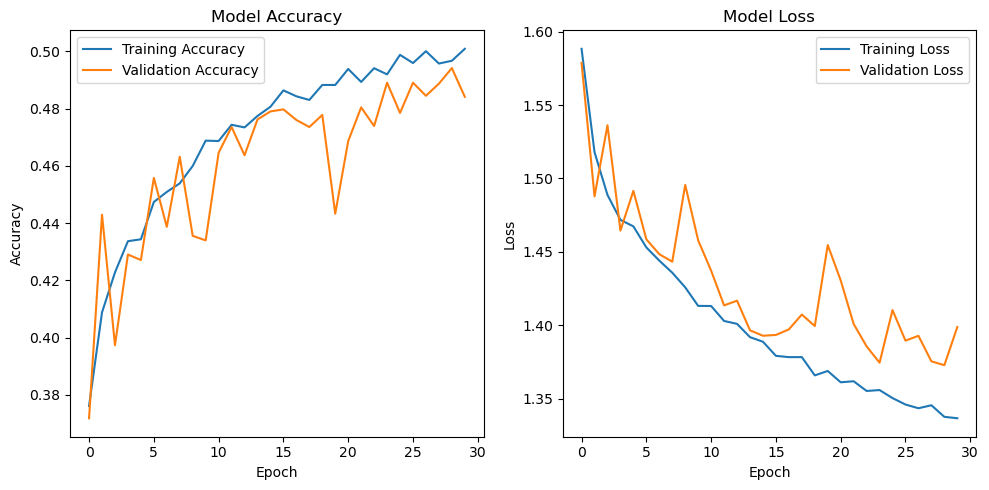

In [12]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Get predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotions))

222/222 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.03      0.06       644
    contempt       0.00      0.00      0.00        51
     disgust       0.00      0.00      0.00        57
        fear       0.85      0.07      0.12       167
   happiness       0.53      0.46      0.49      1827
     neutral       0.49      0.77      0.60      2597
     sadness       0.28      0.04      0.07       856
    surprise       0.43      0.60      0.50       900

    accuracy                           0.49      7099
   macro avg       0.40      0.25      0.23      7099
weighted avg       0.48      0.49      0.43      7099



222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step


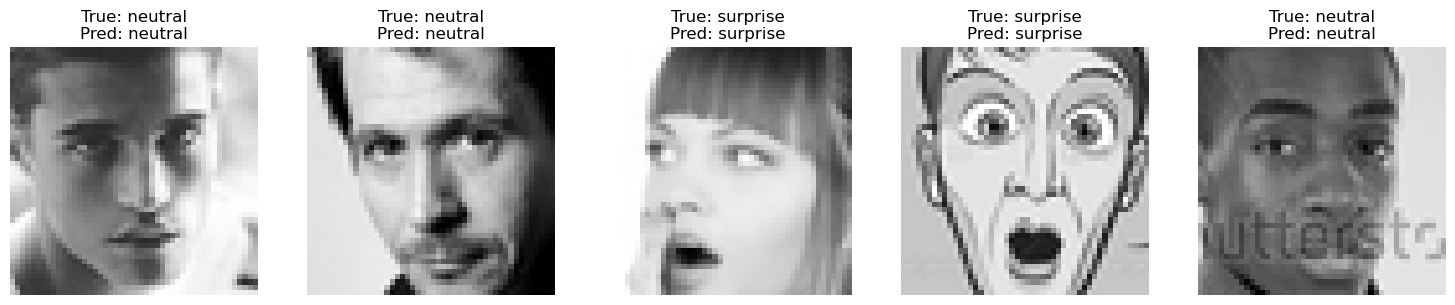

In [40]:
def display_predictions(model, X, y_true, emotions, num_samples=5):
    # Get predictions
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        plt.subplot(1, num_samples, i + 1)
        img = X[idx]
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        if img.ndim == 3:
            img = np.mean(img, axis=2).astype(np.uint8)
        
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(f"True: {emotions[y_true_labels[idx]]}\nPred: {emotions[y_pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(model, X_test, y_test_cat, emotions)

# Model 2: Convolution Neural Networks

In [17]:
def load_images(directory):
    images = []
    labels = []
    for emotion_index, emotion in enumerate(emotions):
        emotion_dir = os.path.join(directory, emotion)
        for img_file in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_file)
            img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(emotion_index)
    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

In [18]:
#feature extraction
def extract_features(images):
    features = np.array(images)
    features = features.reshape(len(features), 48, 48, 1)  
    return features

train_features = extract_features(X_train)
test_features = extract_features(X_test)

In [19]:
# Normalize pixel values
X_train = train_features / 255.0
X_test = test_features / 255.0

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(emotions))
y_test_cat = to_categorical(y_test, num_classes=len(emotions))

In [20]:
input_shape = (48, 48, 1)
output_class = 8
# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(output_class, activation='softmax'))
model.build(input_shape=(None, 48, 48, 1))
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])  

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,232,456 (16.15 MB)

 Trainable params: 4,232,456 (16.15 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train the model
history = model.fit(x=X_train, y=y_train_cat, batch_size=128, epochs=30, validation_data=(X_test, y_test_cat))

Epoch 1/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.3810 - loss: 1.5610 - val_accuracy: 0.4374 - val_loss: 1.4290
Epoch 2/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.4746 - loss: 1.3995 - val_accuracy: 0.6194 - val_loss: 1.1076
Epoch 3/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.5925 - loss: 1.1701 - val_accuracy: 0.6550 - val_loss: 1.0042
Epoch 4/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.6236 - loss: 1.0808 - val_accuracy: 0.6683 - val_loss: 0.9510
Epoch 5/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.6451 - loss: 1.0210 - val_accuracy: 0.6921 - val_loss: 0.8800
Epoch 6/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.6552 - loss: 0.9733 - val_accuracy: 0.6987 - val_loss: 0.8460
Epoch 7/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.6743 - loss: 0.9277 - val_accuracy: 0.7159 - val_loss: 0.8279
Epoch 8/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.6777 - loss: 0.9114 - val_accu

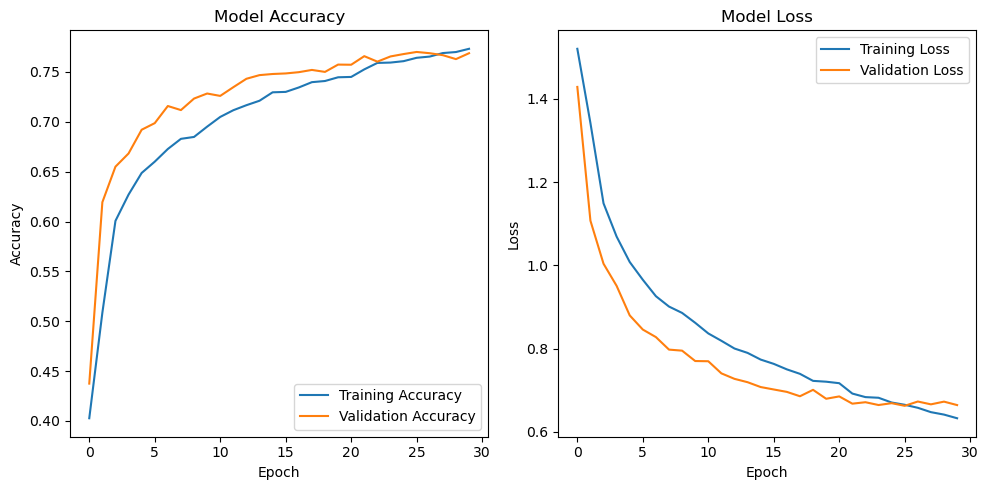

In [27]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7302 - loss: 0.8175
Test accuracy: 0.7688
Test loss: 0.6645


In [28]:
# Get predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotions))

222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.64      0.69       644
    contempt       0.83      0.10      0.18        51
     disgust       0.83      0.18      0.29        57
        fear       0.81      0.26      0.39       167
   happiness       0.88      0.86      0.87      1827
     neutral       0.72      0.90      0.80      2597
     sadness       0.69      0.37      0.48       856
    surprise       0.78      0.85      0.81       900

    accuracy                           0.77      7099
   macro avg       0.79      0.52      0.56      7099
weighted avg       0.77      0.77      0.75      7099



222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step


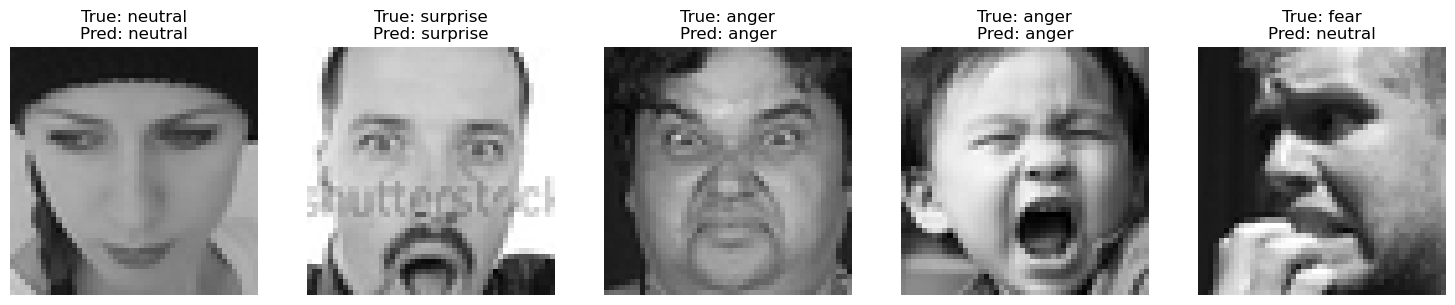

In [34]:
def display_predictions(model, X, y_true, emotions, num_samples=5):
    # Get predictions
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        plt.subplot(1, num_samples, i + 1)
        img = X[idx]
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        if img.ndim == 3:
            img = np.mean(img, axis=2).astype(np.uint8)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(f"True: {emotions[y_true_labels[idx]]}\nPred: {emotions[y_pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(model, X_test, y_test_cat, emotions)

222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step


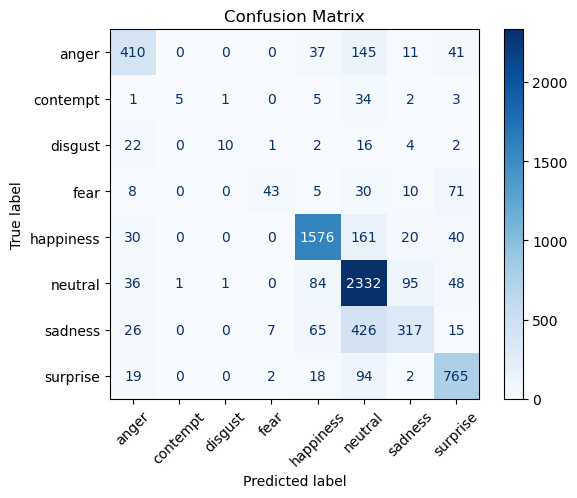

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, class_names):
    # Predict class probabilities
    y_pred_probs = model.predict(X_test)
    
    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Assuming `emotions` is your list of class names
plot_confusion_matrix(model, X_test, y_test_cat, class_names=emotions)
